In [22]:
import numpy as np
import pandas as pd

import tensorflow as tf

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

print(f'x_train: shape {x_train.shape}, type {type(x_train)}')
print(f'y_train: shape {y_train.shape}, type {type(y_train)}')
print(f'x_test: shape {x_test.shape}, type {type(x_test)}')
print(f'y_test: shape {y_test.shape}, type {type(y_test)}')

x_train: shape (60000, 28, 28), type <class 'numpy.ndarray'>
y_train: shape (60000,), type <class 'numpy.ndarray'>
x_test: shape (10000, 28, 28), type <class 'numpy.ndarray'>
y_test: shape (10000,), type <class 'numpy.ndarray'>


In [24]:
# flatten x
def flatten_data(x):
  axis0, axis1, axis2 = x.shape
  return x.reshape(axis0, axis1 * axis2)

x_train = flatten_data(x_train)
x_test = flatten_data(x_test)

# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (60000, 784)
x_test shape: (10000, 784)
y_train shape: (60000,)
y_test shape: (10000,)


In [25]:
# normalize
gray_scale = 255.0

x_train = x_train.astype('float32') / gray_scale
x_test = x_test.astype('float32') / gray_scale

# print(x_train[0])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [27]:
# Define the neural network architecture
hidden_sizes = [128, 64, 32]
n_categories = 10

model = nn.Sequential(
    nn.Linear(in_features=x_train.shape[1], out_features=hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(in_features=hidden_sizes[0], out_features=hidden_sizes[1]),
    nn.Sigmoid(),
    nn.Linear(in_features=hidden_sizes[1], out_features=hidden_sizes[2]),
    nn.ReLU(),
    nn.Linear(in_features=hidden_sizes[2], out_features=n_categories),
    nn.LogSoftmax(dim=1)
)

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [28]:
# Training loop
epochs = 10
batch_size = 64
for epoch in range(epochs):
    permutation = torch.randperm(x_train_tensor.size()[0])
    running_loss = 0.0
    print(f'Epoch {epoch + 1}:', end=' ')
    for i in range(0, x_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = x_train_tensor[indices], y_train_tensor[indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i // batch_size % 100 == 99:
            print(f'Batch {i // batch_size + 1} loss: {running_loss / 100:.3f}', end=' ')
            running_loss = 0.0
    print()  # Newline at the end of each epoch

print('Finished Training')


Epoch 1: Batch 100 loss: 2.304 Batch 200 loss: 2.292 Batch 300 loss: 2.266 Batch 400 loss: 2.073 Batch 500 loss: 1.625 Batch 600 loss: 1.146 Batch 700 loss: 0.791 Batch 800 loss: 0.686 Batch 900 loss: 0.638 
Epoch 2: Batch 100 loss: 0.544 Batch 200 loss: 0.495 Batch 300 loss: 0.495 Batch 400 loss: 0.427 Batch 500 loss: 0.414 Batch 600 loss: 0.381 Batch 700 loss: 0.353 Batch 800 loss: 0.336 Batch 900 loss: 0.319 
Epoch 3: Batch 100 loss: 0.283 Batch 200 loss: 0.282 Batch 300 loss: 0.270 Batch 400 loss: 0.232 Batch 500 loss: 0.225 Batch 600 loss: 0.216 Batch 700 loss: 0.211 Batch 800 loss: 0.213 Batch 900 loss: 0.213 
Epoch 4: Batch 100 loss: 0.196 Batch 200 loss: 0.178 Batch 300 loss: 0.174 Batch 400 loss: 0.170 Batch 500 loss: 0.164 Batch 600 loss: 0.173 Batch 700 loss: 0.151 Batch 800 loss: 0.165 Batch 900 loss: 0.148 
Epoch 5: Batch 100 loss: 0.138 Batch 200 loss: 0.128 Batch 300 loss: 0.132 Batch 400 loss: 0.131 Batch 500 loss: 0.129 Batch 600 loss: 0.139 Batch 700 loss: 0.126 Batch

In [32]:
# Test the model
correct = 0
total = 0
all_preds = []
with torch.no_grad():
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    total += y_test_tensor.size(0)
    correct += (predicted == y_test_tensor).sum().item()
    all_preds = predicted.numpy()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# Calculate the confusion


Accuracy of the network on the 10000 test images: 97.12%


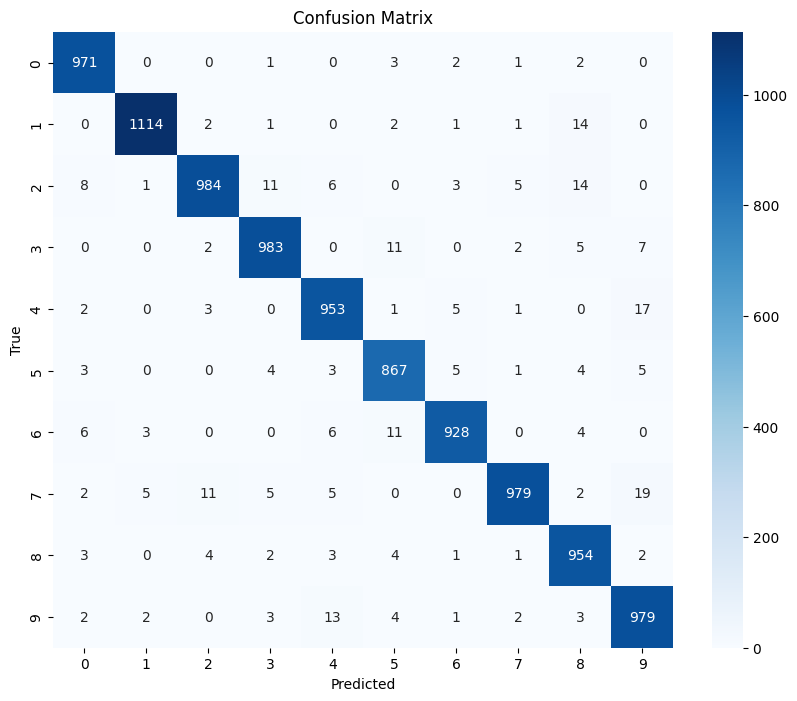

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the trained model
torch.save(model.state_dict(), './mnist_net.pth')